In [9]:
import torch
from matplotlib import pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    DEVICE = torch.device('cpu')
    torch.set_default_tensor_type(torch.FloatTensor)

In [211]:
RES = 0.05
NPIX = 100
Z_LENS = 1
Z_SOURCE = 2
SIGMA = 2

In [212]:
from typing import Union, Optional, Iterator
from collections import defaultdict
from tqdm import tqdm

from sling.utils import get_meshgrid, downsample
import sling.lenses as ls
import sling.sources as ss

Tensor = torch.Tensor


def _make_dict_sersic(z_sersic: Tensor) -> dict:
    return dict(
        x=z_sersic[0],
        y=z_sersic[1],
        phi=z_sersic[2],
        q=z_sersic[3],
        index=z_sersic[4],
        r_e=z_sersic[5],
        I_e=z_sersic[6],
    )
          
def _make_dict_lens(z_lens: Tensor) -> dict:
    return dict(
        x=z_lens[0],
        y=z_lens[1],
        phi=z_lens[2],
        q=z_lens[3],
        r_ein=z_lens[4],
        gamma=z_lens[5],
    )

def _make_dict_shear(z_shear: Tensor) -> dict:
    return dict(
        gamma_1=z_shear[0],
        gamma_2=z_shear[1]
    )
    
def _make_dict_multipole(z_multipole: Tensor) -> dict:
    return dict(
        x=z_multipole[0],
        y=z_multipole[1],
        m=z_multipole[2],
        a_m=z_multipole[3],
        phi_m=z_multipole[4]
    )
    

def _uniform_prior(
    bounds: Optional[dict[str, Tensor]],
    low_init: Optional[Union[list, Tensor]] = None,
    high_init: Optional[Union[list, Tensor]] = None,
    device: str = 'cuda',
) -> Tensor:
    """
    Flexible uniform prior function for the specified parameter with the
    specified initial lower and upper bounds, they can be the initialized one
    or the one from swyft bounds.

    Args:
        name (str): swyft.Simulator parameter name
        low_init (Union[list, Tensor]): parameter lower bound
        high_init (Union[list, Tensor]): parameter upper bound
        bounds (Optional[dict[str, Tensor]]): swyft bounds
        device (str): "cuda" or "cpu"

    Returns:
        Tensor: draws from the prior
    """

    if bounds is None and low_init is None:
        raise NameError("Initial low and upper values or bounds not found.")
   
    if bounds is not None:
        low = bounds[..., :, 0].to(device)
        high = bounds[..., :, 1].to(device)
    else:
        low = low_init
        high = high_init
        
    assert low.size() == high.size()
    assert low.ndim == 0 or high.ndim == 1
    assert high.ndim == 0 or high.ndim == 1
    nz = low.size()

    draw = torch.rand(nz, device=device) * (high - low) + low
    return draw


class LensingBuildingBlocks:
    def __init__(
        self, 
        alpha: list[str] = ["lens", "shear", "multipole"], 
        source: list[str] = ["sersic"],  
        light: Optional[list[str]]= ["sersic"]
    ):
        # Check the correctness of specified building blocks
        assert all(elem in ["lens", "shear",  "multipole"] for elem in alpha) if alpha is not None else True
        assert all(elem in ["sersic"] for elem in source)
        assert all(elem in ["sersic"] for elem in light) if light is not None else True
        
        # There can be no light
        assert len(source) == 1
        assert len(light) == 0 or len(light) == 1
        
        self.alpha = alpha
        self.source = source
        self.light = light
        

class LensingSimulator():

    def __init__(
        self,
        lensing_building_blocks: LensingBuildingBlocks, 
        priors_dict: dict[str, Tensor],
        res: float, 
        n_pix: int, 
        n_pix_src: int,
        upsample: int = 10,
        sigma_n: float = 0.01,
        redshift_lens: float =  0.881, 
        redshift_src: float = 2.059,
        device: str = 'cuda',
    ):
        super().__init__()
        self.device = device
        
        self.res = res
        self.n_pix = n_pix
        self.n_pix_src = n_pix_src
        self.upsample = upsample
        self.X, self.Y = self._get_XY(self.res, self.n_pix)

        # Redshift
        self.redshift_lens = redshift_lens
        self.redshift_src = redshift_src
        
        # Noise level
        self.sigma_n = sigma_n
        
        # Lensing system components
        self.lbb = lensing_building_blocks
        self.alpha = self._set_alpha(self.lbb.alpha) if self.lbb.alpha is not None else {}
        self.source = self._set_source(self.lbb.source) if self.lbb.source is not None else {}
        self.light = self._set_source(self.lbb.light) if self.lbb.light is not None else {}
        self.coerce_XY(self.X, self.Y)

        # Lensing priors
        self.priors_dict = priors_dict
            
    def _get_XY(self, res: float, n_pix: int):
        return get_meshgrid(res, n_pix, n_pix, self.device)
    
    def _set_alpha(self, alpha_components: list[str]) -> dict:
        alphas_options = {
            "lens": ls.SPLELens(z_lens=self.redshift_lens, device=self.device),
            "shear": ls.ExternalShear(device=self.device),
            "multipole": ls.Multipole(device=self.device)
        }
        
        for k in alpha_components:
            if k not in alphas_options.keys():
                raise ValueError(f"Accepted alphas components are: {alphas_options.keys()}.")

        return {k: alphas_options[k] for k in alpha_components}

    def _set_source(self, source_components: list[str]) -> dict:
        sources_options = {
            "sersic": ss.SersicSource(device=self.device),
        }
        
        for k in source_components:
            if k not in sources_options.keys():
                raise ValueError(f"Accepted source components are: {sources_options.keys()}.")

        return {k: sources_options[k] for k in source_components}
       
    def coerce_XY(self, X: Tensor = None, Y: Tensor = None):
        self.X = X
        self.Y = Y
        for alpha in self.alpha.values():
            alpha.XY = self.X, self.Y
        
    def prior(self, parname: str):
        prior = self.priors_dict[parname]
        if isinstance(prior, Tensor):
            draw =  _uniform_prior(bounds=prior, device=self.device)
        elif isinstance(prior, Iterator):
            draw = next(prior)
        else:
            raise TypeError("Prior can be Torch.Tensor bounds or Dataset.")
        
        return draw
    
    def _alphas_kwargs(self, z_lens: Tensor = None, z_shear: Tensor = None, z_multipole: Tensor = None) -> dict:
        # Collect alphas kwargs
        lens_kwargs = _make_dict_lens(z_lens) if z_lens is not None else None
        shear_kwargs = _make_dict_shear(z_shear) if z_shear is not None else None
        multipole_kwargs = _make_dict_multipole(z_multipole) if z_multipole is not None else None
        return dict(lens=lens_kwargs, shear=shear_kwargs, multipole=multipole_kwargs)
    
    def _source_kwargs(self, z_sersic: Tensor = None) -> dict:
        # Collect source kwargs
        sersic_kwargs = _make_dict_sersic(z_sersic) if z_sersic is not None else None
        return dict(sersic=sersic_kwargs)
         
    def raytrace(self, 
                 z_lens: Tensor = None, z_shear: Tensor = None, z_multipole: Tensor = None, 
                 z_sersic: Tensor = None):
        # torch.set_default_tensor_type(torch.cuda.DoubleTensor) 

        # Get kwargs
        alphas_kwargs = self._alphas_kwargs(z_lens=z_lens, z_shear=z_shear, z_multipole=z_multipole)
        source_kwargs = self._source_kwargs(z_sersic=z_sersic)
        
        # Upsample
        if self.upsample !=None:
            _X, _Y = self.X, self.Y
            X_fine, Y_fine = get_meshgrid(
                self.res / self.upsample,
                self.n_pix * self.upsample,
                self.n_pix * self.upsample,
                device=self.device,
            )
            # Switch self.X, self.Y and alpha grids to fine one
            self.coerce_XY(X_fine, Y_fine)

        # Displacement
        alphas = torch.stack(
            [a(**alphas_kwargs[k]) for k, a in self.alpha.items()]
        ).sum(0)
        
        # Apply lensing equation
        X_src = self.X - alphas[..., 0, :, :]
        Y_src = self.Y - alphas[..., 1, :, :]
        
        # Eval source
        mus = {k: s(X=X_src, Y=Y_src, **source_kwargs[k]) for k, s in self.source.items()}
        mu = mus[self.lbb.source[0]]

        # Downsample
        if self.upsample != None:
            assert mu.shape[-2:] == (self.n_pix * self.upsample, self.n_pix * self.upsample)
            mu = downsample(mu, self.upsample)
            X_src = downsample(X_src, self.upsample)
            Y_src = downsample(Y_src, self.upsample)
            # Restore grid
            self.X, self.Y = _X, _Y
            
        # torch.set_default_tensor_type(torch.cuda.FloatTensor) 

        return X_src, Y_src, mu
          
    def eval_light(self, z_sersic: Tensor = None):
        
        # Get kwargs
        light_kwargs = self._source_kwargs(z_sersic=z_sersic)
            
        # Evaluate lens light
        if self.lbb.light is None:
            mu = torch.zeros([self.n_pix, self.n_pix], device=self.device)
        else:
            mus = {k: s(X=self.X, Y=self.Y, **light_kwargs[k]) for k, s in self.light.items()} if self.light is not None else None
            mu = mus[self.lbb.light[0]]
      
        return mu
          
    def eval_source(self, z_sersic: Tensor = None):
        
        # Get kwargs
        source_kwargs = self._source_kwargs(z_sersic=z_sersic)

        X_src, Y_src = get_meshgrid(
            1 / self.n_pix_src,
            self.n_pix_src,
            self.n_pix_src,
            device=self.device,
        )
                        
        # Evaluate source light
        mus = {k: s(X=X_src, Y=Y_src, **source_kwargs[k]) for k, s in self.source.items()}
        mu = mus[self.lbb.source[0]]
        return mu

    def get_noise(self, mu_lens: Tensor = None):
        return torch.randn(mu_lens.shape, device=self.device) * self.sigma_n
    
    def get_img(self, mu_light: Tensor = None, mu_lens: Tensor = None, noise: Tensor = None):
        mu = mu_light + mu_lens
        # if self.psf is not None:
        #     mu = self.psf(mu)
        return mu + noise
    
    def _sample_base(self):
            
        z_lens = self.prior("z_lens") if "lens" in self.lbb.alpha else None
        z_shear = self.prior("z_shear") if "shear" in self.lbb.alpha else None
        if "multipole" in self.lbb.alpha:
            z_multipole = self.prior("z_multipole")
            z_multipole = torch.cat([z_lens[:2], z_multipole]) 
        else:
            z_multipole = None
            
        z_sersic_source =  self.prior("z_sersic_source") if "sersic" in self.lbb.source else None
        # Light
        if self.lbb.light is not None:
            z_sersic_light = self.prior("z_sersic_light") if "sersic" in self.lbb.light else None
        else:
            z_sersic_light = None
    
        mu_light = self.eval_light(z_sersic_light)
        mu_source = self.eval_source(z_sersic_light)
        if self.lbb.alpha is not None:
            X_src, Y_src, mu_lens0 = self.raytrace(z_lens, z_shear, None,
                                            z_sersic_source
                                            )  
            
            X_src, Y_src, mu_lens1 = self.raytrace(z_lens, z_shear, z_multipole,
                                            z_sersic_source
                                            )  
                
            # Noise
            noise = self.get_noise(mu_lens0)
            img0 = self.get_img(mu_light, mu_lens0, noise) 
            img1 = self.get_img(mu_light, mu_lens1, noise) 
            
        return {
            'z_lens': z_lens,
            'z_shear': z_shear,
            'z_multipole': z_multipole,
            'z_sersic_source': z_sersic_source,
            'z_sersic_light': z_sersic_light,
            'mu_light': mu_light,
            'mu_source': mu_source,
            'X_src': X_src,
            'Y_src': Y_src,
            'mu_lens0': mu_lens0,
            'mu_lens1': mu_lens1,
            'noise': noise,
            'img0': img0,
            'img1': img1
        }
            
    # def _sample(self):
    #     sample = {}
    #     if self.bkg:
    #         z = self.get_z()
    #         mu = self.get_mu(z)
    #         sample['z'] = z
    #         sample['mu'] = mu
    #         x0 = self.get_x_H0(mu)
    #     else:
    #         x0 = self.get_x_H0(0)
    #     epsilon = self.get_augment_mask(x0)
    #     x1 = self.get_x_H1(epsilon, x0)
    #     return sample | {'x0': x0, 'epsilon': epsilon, 'x1': x1}
    
    # def sample(self, Nsims=1, show_progress=True):
    #     if show_progress:
    #         samples_list = [self._sample() for _ in tqdm(range(Nsims))]
    #     else:  
    #         samples_list = [self._sample() for _ in range(Nsims)]
    #     samples_dict = defaultdict(list)
    #     for d in samples_list:
    #         for key, value in d.items():
    #             samples_dict[key].append(value)
    #     for key, value in d.items():
    #         samples_dict[key] = torch.stack(samples_dict[key])
    #     return samples_dict 

In [213]:
import swyft   

class SwyftLensingSimulator(swyft.Simulator):

    def __init__(
        self,
        lensing_building_blocks: LensingBuildingBlocks, 
        priors_dict: dict[str, Tensor],
        res: float, 
        n_pix: int, 
        n_pix_src: int,
        upsample: int = 10,
        sigma_n: float = 0.01,
        redshift_lens: float =  0.881, 
        redshift_src: float = 2.059,
        device: str = 'cuda',
    ):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.device = device
        
        self.res = res
        self.n_pix = n_pix
        self.n_pix_src = n_pix_src
        self.upsample = upsample
        self.X, self.Y = self._get_XY(self.res, self.n_pix)

        # Redshift
        self.redshift_lens = redshift_lens
        self.redshift_src = redshift_src
        
        # Noise level
        self.sigma_n = sigma_n
        
        # Lensing system components
        self.lbb = lensing_building_blocks
        self.alpha = self._set_alpha(self.lbb.alpha) if self.lbb.alpha is not None else {}
        self.source = self._set_source(self.lbb.source) if self.lbb.source is not None else {}
        self.light = self._set_source(self.lbb.light) if self.lbb.light is not None else {}
        self.coerce_XY(self.X, self.Y)

        # Lensing priors
        self.priors_dict = priors_dict
            
    def _get_XY(self, res: float, n_pix: int):
        return get_meshgrid(res, n_pix, n_pix, self.device)
    
    def _set_alpha(self, alpha_components: list[str]) -> dict:
        alphas_options = {
            "lens": ls.SPLELens(z_lens=self.redshift_lens, device=self.device),
            "shear": ls.ExternalShear(device=self.device),
            "multipole": ls.Multipole(device=self.device)
        }
        
        for k in alpha_components:
            if k not in alphas_options.keys():
                raise ValueError(f"Accepted alphas components are: {alphas_options.keys()}.")

        return {k: alphas_options[k] for k in alpha_components}

    def _set_source(self, source_components: list[str]) -> dict:
        sources_options = {
            "sersic": ss.SersicSource(device=self.device),
        }
        
        for k in source_components:
            if k not in sources_options.keys():
                raise ValueError(f"Accepted source components are: {sources_options.keys()}.")

        return {k: sources_options[k] for k in source_components}
       
    def coerce_XY(self, X: Tensor = None, Y: Tensor = None):
        self.X = X
        self.Y = Y
        for alpha in self.alpha.values():
            alpha.XY = self.X, self.Y
        
    def prior(self, parname: str):
        prior = self.priors_dict[parname]
        if isinstance(prior, Tensor):
            draw =  _uniform_prior(bounds=prior, device=self.device)
        elif isinstance(prior, Iterator):
            draw = next(prior)
        else:
            raise TypeError("Prior can be Torch.Tensor bounds or Dataset.")
        
        return draw
    
    def _alphas_kwargs(self, z_lens: Tensor = None, z_shear: Tensor = None, z_multipole: Tensor = None) -> dict:
        # Collect alphas kwargs
        kwargs = {}
        if z_lens is not None:
            kwargs["lens"] = _make_dict_lens(z_lens)
        if z_shear is not None:
             kwargs["shear"] = _make_dict_shear(z_shear)
        if z_multipole is not None:
             kwargs["multipole"] = _make_dict_multipole(z_multipole)
        return kwargs
    
    def _source_kwargs(self, z_sersic: Tensor = None) -> dict:
        # Collect source kwargs
        sersic_kwargs = _make_dict_sersic(z_sersic) if z_sersic is not None else None
        return dict(sersic=sersic_kwargs)
         
    def raytrace(self, 
                 z_lens: Tensor = None, z_shear: Tensor = None, z_multipole: Tensor = None, 
                 z_sersic: Tensor = None):
        # torch.set_default_tensor_type(torch.cuda.DoubleTensor) 

        # Get kwargs
        alphas_kwargs = self._alphas_kwargs(z_lens=z_lens, z_shear=z_shear, z_multipole=z_multipole)
        source_kwargs = self._source_kwargs(z_sersic=z_sersic)
        
        # Upsample
        if self.upsample !=None:
            _X, _Y = self.X, self.Y
            X_fine, Y_fine = get_meshgrid(
                self.res / self.upsample,
                self.n_pix * self.upsample,
                self.n_pix * self.upsample,
                device=self.device,
            )
            # Switch self.X, self.Y and alpha grids to fine one
            self.coerce_XY(X_fine, Y_fine)

        # Displacement
        alphas = torch.stack(
            [self.alpha[k](**alphas_kwargs[k]) for k in alphas_kwargs.keys()]
        ).sum(0)
        
        # Apply lensing equation
        X_src = self.X - alphas[..., 0, :, :]
        Y_src = self.Y - alphas[..., 1, :, :]
        
        # Eval source
        mus = {k: s(X=X_src, Y=Y_src, **source_kwargs[k]) for k, s in self.source.items()}
        mu = mus[self.lbb.source[0]]

        # Downsample
        if self.upsample != None:
            assert mu.shape[-2:] == (self.n_pix * self.upsample, self.n_pix * self.upsample)
            mu = downsample(mu, self.upsample)
            X_src = downsample(X_src, self.upsample)
            Y_src = downsample(Y_src, self.upsample)
            # Restore grid
            self.X, self.Y = _X, _Y
            
        # torch.set_default_tensor_type(torch.cuda.FloatTensor) 

        return X_src, Y_src, mu
          
    def eval_light(self, z_sersic: Tensor = None):
        
        # Get kwargs
        light_kwargs = self._source_kwargs(z_sersic=z_sersic)
            
        # Evaluate lens light
        if self.lbb.light is None:
            mu = torch.zeros([self.n_pix, self.n_pix], device=self.device)
        else:
            mus = {k: s(X=self.X, Y=self.Y, **light_kwargs[k]) for k, s in self.light.items()} if self.light is not None else None
            mu = mus[self.lbb.light[0]]
      
        return mu
          
    def eval_source(self, z_sersic: Tensor = None):
        
        # Get kwargs
        source_kwargs = self._source_kwargs(z_sersic=z_sersic)

        X_src, Y_src = get_meshgrid(
            1 / self.n_pix_src,
            self.n_pix_src,
            self.n_pix_src,
            device=self.device,
        )
                        
        # Evaluate source light
        mus = {k: s(X=X_src, Y=Y_src, **source_kwargs[k]) for k, s in self.source.items()}
        mu = mus[self.lbb.source[0]]
        return mu

    def get_noise(self, mu_lens: Tensor = None):
        return torch.randn(mu_lens.shape, device=self.device) * self.sigma_n
    
    def get_img(self, mu_light: Tensor = None, mu_lens: Tensor = None, noise: Tensor = None):
        mu = mu_light + mu_lens
        # if self.psf is not None:
        #     mu = self.psf(mu)
        return mu + noise
    
    
    def build(self, graph):
        
        # Alphas
        if self.lbb.alpha is not None:
            z_lens = graph.node("z_lens", self.prior, "z_lens") if "lens" in self.lbb.alpha else None
            z_shear = graph.node("z_shear", self.prior, "z_shear") if "shear" in self.lbb.alpha else None
            if "multipole" in self.lbb.alpha:
                z_multipole = self.prior("z_multipole")
                z_multipole = graph.node("z_multipole", lambda z_lens, z_multipole: torch.cat([z_lens[:2], z_multipole]), z_lens, z_multipole)
            else:
                z_multipole = None
        else:
            z_lens, z_shear, z_sub = None, None, None
        # Source
        z_sersic_source =  graph.node("z_sersic_source", self.prior, "z_sersic_source") if "sersic" in self.lbb.source else None
        # Light
        if self.lbb.light is not None:
            z_sersic_light = graph.node("z_sersic_light", self.prior, "z_sersic_light") if "sersic" in self.lbb.light else None
        else:
            z_sersic_light = None
            
        mu_light = graph.node("mu_light", self.eval_light, z_sersic_light)
        mu_source = graph.node("mu_source", self.eval_source, z_sersic_source)
        if self.lbb.alpha is not None:
            X_src0, Y_src0, mu_lens0 = graph.node(["X_src0", "Y_src0", "mu_lens0"], 
                                            self.raytrace, 
                                            z_lens, z_shear, None, z_sersic_source
                                            )
            
            X_src1, Y_src1, mu_lens1 = graph.node(["X_src1", "Y_src1", "mu_lens1"], 
                                            self.raytrace, 
                                            z_lens, z_shear, z_multipole, z_sersic_source
                                            )
            # Noise
            noise = graph.node("noise", self.get_noise, mu_lens0)
            img0 = graph.node("img0", self.get_img, mu_light, mu_lens0, noise)
            img1 = graph.node("img1", self.get_img, mu_light, mu_lens1, noise)

In [214]:
# Initial prior

bounds_init = {}

bounds_init['z_lens'] = torch.tensor([
    [0., 0. + 1e-3],
    [0., 0. + 1e-3],
    [1., 1.+ 1e-3],
    [0.5, 0.5 + 1e-3],
    [1.4, 1.4+ 1e-3],
    [2, 2 + 1e-3],
])

bounds_init['z_shear'] = torch.tensor([[0., 0.], [0., 0.]])

bounds_init['z_multipole'] = torch.tensor([[3, 3], [0.1, 0.1], [0., 0.]])

bounds_init['z_sersic_source'] = torch.tensor([
    [0., 0. + 1e-3],
    [0., 0. + 1e-3],
    [1., 1.],
    [0.5, .5],
    [2, 2.],
    [1, 1],
    [2., 2.]
])

bounds_init['z_sersic_light'] = torch.tensor([
    [0., 0. + 1e-3],
    [0., 0. + 1e-3],
    [1., 1.],
    [0.5, .5],
    [2, 2.],
    [1, 1],
    [2., 2.]
])

lensing_building_blocks = LensingBuildingBlocks(
        alpha = ["lens", "shear", "multipole"], 
        source = ["sersic"],  
        # light = ["sersic"]
    )

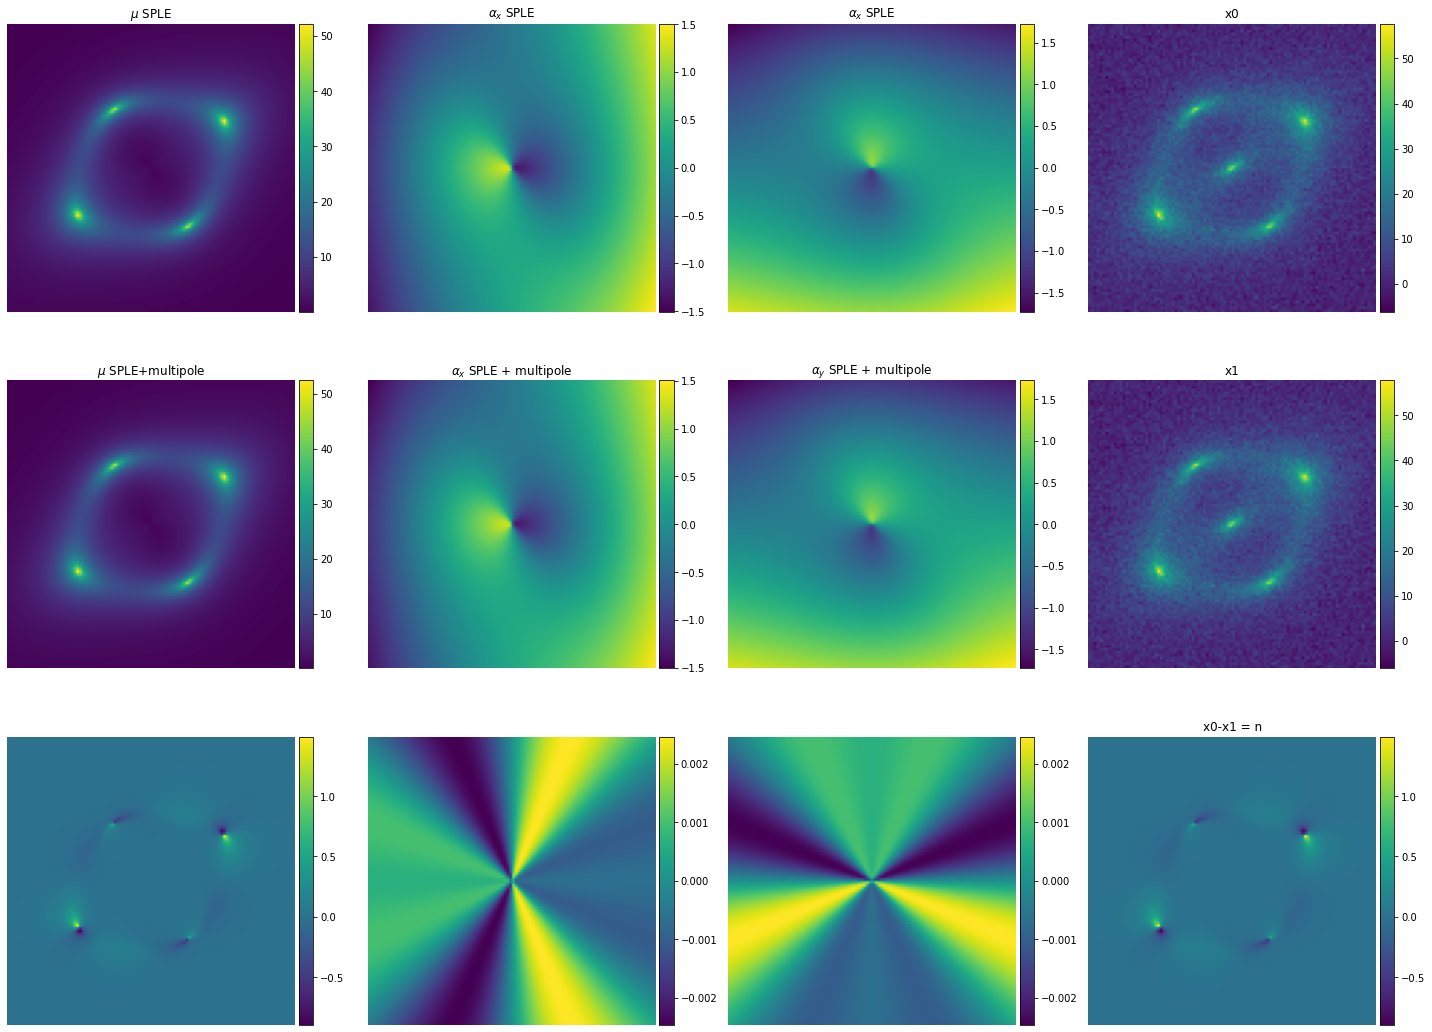

In [221]:
# Effect of multipole

from sling.plotting import imshow_with_cbar

lensing_building_blocks = LensingBuildingBlocks(
        alpha = ["lens", "multipole"], 
        source = ["sersic"],  
        # light = ["sersic"]
    )

sim = SwyftLensingSimulator(
        lensing_building_blocks, bounds_init,
        RES, NPIX, 60, sigma_n=SIGMA, device=DEVICE, upsample=10
    )

# a_m max = 0.03
sample = sim.sample(conditions={"z_multipole": [0., 0., 4. ,.01, 0.]})

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()
imshow_with_cbar(sample['mu_lens0'], ax=axs[0])
axs[0].set_title(r"$\mu$ SPLE")
imshow_with_cbar(sample['X_src0'], ax=axs[1])
axs[1].set_title(r"$\alpha_x$ SPLE")
imshow_with_cbar(sample['Y_src0'], ax=axs[2])
axs[2].set_title(r"$\alpha_x$ SPLE")
imshow_with_cbar(sample['img0'], ax=axs[3])
axs[3].set_title(r"x0")

imshow_with_cbar(sample['mu_lens1'], ax=axs[4])
axs[4].set_title(r"$\mu$ SPLE+multipole")
imshow_with_cbar(sample['X_src1'], ax=axs[5])
axs[5].set_title(r"$\alpha_x$ SPLE + multipole")
imshow_with_cbar(sample['Y_src1'], ax=axs[6])
axs[6].set_title(r"$\alpha_y$ SPLE + multipole")
imshow_with_cbar(sample['img1'], ax=axs[7])
axs[7].set_title(r"x1")

imshow_with_cbar(sample['mu_lens0']-sample['mu_lens1'], ax=axs[8])
imshow_with_cbar(sample['X_src0']-sample['X_src1'], ax=axs[9])
imshow_with_cbar(sample['Y_src0']-sample['Y_src1'], ax=axs[10])
imshow_with_cbar(sample['img0']-sample['img1'], ax=axs[11])
axs[11].set_title(r"x0-x1 = n")

for ax in axs: ax.axis('off')
plt.tight_layout();